In [1]:
import os
import glob

from spectrum import Spectrum

from pyteomics import mzml

import matplotlib.pyplot as plt

### Import DB

In [2]:
db_path = 'results/database_trap'
file_list = os.listdir(db_path)  # A list of all the files in the folder

spectra_db = []
for file in file_list:
    if file.endswith('.txt'):
        file_path = os.path.join(db_path, file)
        with open(file_path, 'r') as f:
            lines = f.readlines()
            file_data = {}
            for line in lines:
                key, value = line.strip().split(': ')
                if key in ['mz', 'intensities']:
                    value = [float(v) for v in value[1:-1].split(', ')]
                elif key in ['array_length']:
                    value = int(value)
                else:
                    value = value
                file_data[key] = value

            mz = file_data.pop('mz')
            intensities = file_data.pop('intensities')
            substance_name = file_data.pop('substance_name')

            # Создание объекта Spectrum
            spectrum = Spectrum(mz, intensities, substance_name, **file_data)
            spectra_db.append(spectrum)

### Import test spectra

In [3]:
mzml_files = glob.glob('data/database_trap/test/*.mzml')  # List of all mzml files in the data/database_trap/test

spectra_test = []
step = 1  # Sampling step

for file_path in mzml_files:
#     print(f'A .mzml file has been detected: {file_path}')

    file_name = os.path.splitext(os.path.basename(file_path))[0]
    ms_data = mzml.read(file_path)
    spectrum = list(ms_data)[0]

    mz = spectrum.pop('m/z array')
    intensities = spectrum.pop('intensity array')

    metadata = {'file_name': file_name}
    substance_name = 'Unknown substance'
    spectrum = Spectrum(mz, intensities, substance_name, **metadata)  # Create a Spectrum object
    spectrum.resample(step) # Changing the sampling step

    spectra_test.append(spectrum)

print('An example of a spectrum with metadata obtained on the Trap:')
print(vars(spectra_test[0]))

An example of a spectrum with metadata obtained on the Trap:
{'mz': array([  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
        47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
        58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,
        69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101.,
       102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112.,
       113., 114., 115., 116., 117., 118., 119., 120., 121.]), 'intensities': array([0.00000000e+00, 2.18701400e+07, 4.23182000e+07, 8.05673000e+06,
       6.59322000e+06, 6.02519150e+06, 5.45643100e+06

### Load background spectrum

In [4]:
file_path = 'data/database_trap/background/Background.mzml'
ms_data = mzml.read(file_path)
spectrum_bg = list(ms_data)[0]
mz = spectrum_bg.pop('m/z array')
intensities = spectrum_bg.pop('intensity array')
metadata = {}
substance_name = 'Air'
spectrum_bg = Spectrum(mz, intensities, substance_name, **metadata)  # Create a Spectrum object
spectrum_bg.resample(step) # Changing the sampling step

print("Background spectrum obtained on the Trap:")
print(vars(spectrum_bg))

Background spectrum obtained on the Trap:
{'mz': array([  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
        47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
        58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,
        69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101.,
       102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112.,
       113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123.,
       124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134.,
       135., 136., 137., 138., 139., 140., 141., 142., 143., 144., 145.,
  

### Background spectrum subtraction from test spectra, normalization and filtering

In [5]:
threshold = 0.001
for spectrum in spectra_test:
    spectrum.background_subtraction(spectrum_bg)  # Subtract the background spectrum from the database spectrum
    spectrum.normalize()  # Min-max normalization
    spectrum.apply_threshold(threshold) # Cutting off values below the threshold

### Detect substance (Chloroform) from the db

In [6]:
test_spectrum = None
for spectrum in spectra_test:
    if spectrum.metadata.get('file_name') == 'Chloroform':
        test_spectrum = spectrum
        break

cos_measures = test_spectrum.cosine_measures_list(spectra_db)

# Results output
for measure in cos_measures:
    print(f"substance_name: {measure['substance_name']}, cosine_measure: {measure['cm']:.4f}")

substance_name: Toluene, cosine_measure: 0.0016
substance_name: Hexane, cosine_measure: 0.0482
substance_name: Cyclohexane, cosine_measure: 0.1816
substance_name: Pyridine, cosine_measure: 0.0166
substance_name: Butyl acetate, cosine_measure: 0.0214
substance_name: 1,4-Dioxane, cosine_measure: 0.1394
substance_name: Ethyl acetate, cosine_measure: 0.1186
substance_name: Aniline, cosine_measure: 0.0336
substance_name: Propan-2-ol, cosine_measure: 0.0190
substance_name: Chloroform, cosine_measure: 0.8873
substance_name: Dimethyl sulfoxide, cosine_measure: 0.0614
substance_name: Dimethylformamide, cosine_measure: 0.0690
substance_name: Benzene, cosine_measure: 0.0025
substance_name: Nitromethane, cosine_measure: 0.0750


A substance is considered found if the cosine measure is greater than or equal to 0.8


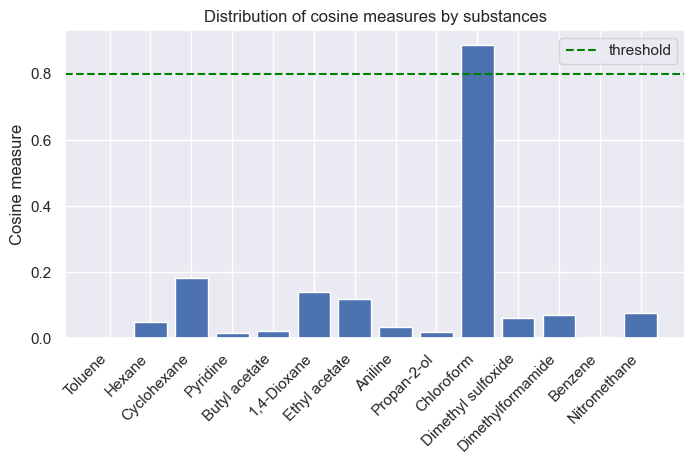

In [7]:
threshold = 0.8
names = [cos_measure['substance_name'] for cos_measure in cos_measures]
cms = [cos_measure['cm'] for cos_measure in cos_measures]

print(f'A substance is considered found if the cosine measure is greater than or equal to {threshold}')

plt.figure(figsize=(8,4))
plt.bar(range(len(cos_measures)), cms)
plt.axhline(y=threshold, color='green', linestyle='--', label='threshold')
plt.xticks(range(len(cos_measures)), names, rotation=45, ha='right')
plt.ylabel('Cosine measure')
plt.title('Distribution of cosine measures by substances')
plt.legend()
plt.show()